# Project 1: Snowpack Prediction at Berthoud Summit
#### This notebook shows the method that was used in order to predict the snow depth at Berthoud Summit on March 24, 2021.
## Made by: Mohammed Alnasser and Jassim Alshouq
## Date: 3/9/2021

# Part 1: Loading the data


In [1]:
#importing libraries
from os import listdir
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as plt_date

In [2]:
# picking the range of years to graph and use for prediction
start_year = 2018
end_year = 2021

# making a dictionary for the data for each year
data_str = {}
for filename in listdir():
    if filename.endswith(".csv"):
        if(start_year <= int(filename[-8:-4]) <= end_year or int(filename[-8:-4])==2021):
            data_str[int(filename[-8:-4])] = np.genfromtxt(filename, 
                                                           skip_header=5,
                                                           delimiter=",",
                                                           usecols=(1,-2),
                                                           dtype=str)

#making a lambda for the date format
str2date = lambda x: dt.datetime.strptime(x, '%Y-%m-%d')

# converting data types (date to datetime and snow depth to float)
data = {}
for year in data_str.keys():
    data[year] = [np.array([str2date(i) for i in data_str[year][:,0]]), np.array([float(i) if float(i) > 0 else 0 for i in data_str[year][:,1]])]


# Part 2: Graphing

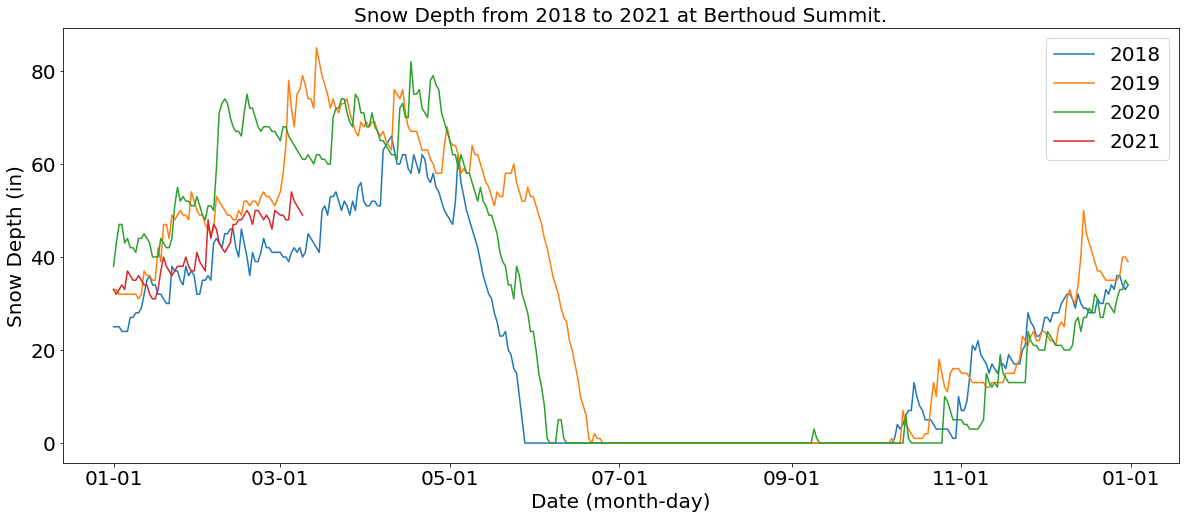

In [3]:
fig, ax = plt.subplots(figsize=(20,8))


# plot all the data and collect it in a dictionary to be used later
data_each_day = {}
jan1 = plt_date.date2num(dt.date(2020,1,1)) # using 2020 as the base year for graphing each month and day
feb29 = plt_date.date2num(dt.date(2020,2,29))
for year in data.keys():
    if not start_year <= year <= end_year:
        continue
    dates_plot = plt_date.date2num(data[year][0])
    start_of_this_year = dates_plot[0]
    for i, date in enumerate(dates_plot):
        dates_plot[i] = jan1 + date - start_of_this_year # make the data points start in 2020 so they all will be in one graph
        if dates_plot[i]>=feb29 and year%4!=0: # account for years that do not have February 29
            dates_plot[i] += 1
        data_each_day.setdefault(dates_plot[i], []).append(data[year][1][i])
    plt.plot_date(dates_plot, data[year][1], '-', label=year)
    
# configure graph
plt.title('Snow Depth from %s to %s at Berthoud Summit.' % (start_year, end_year), fontsize=20)
plt.xlabel('Date (month-day)', fontsize=20)
ax.xaxis.set_major_formatter(plt_date.DateFormatter("%m-%d"))
plt.ylabel('Snow Depth (in)', fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(labelsize=20)
plt.show()


# Part 3: Extrapolating data and predicting snow depth in March 23, 2020

Predicted Snow Depth in March 24, 2021 is 61.1in.


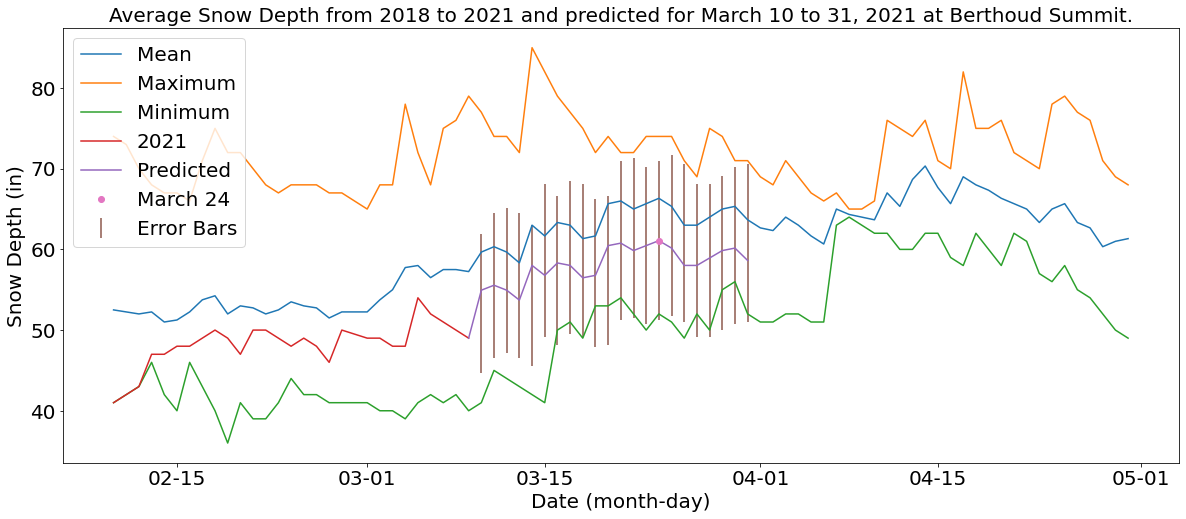

In [5]:
# specify the range to be plotted
data_plot_start = 40
data_plot_end = 120

# calculating the mean, maximum, and minimum snow depths for all the years
mean_data = {}
max_data = {}
min_data = {}
for day in data_each_day.keys():
    mean_data[day] = sum(data_each_day[day])/len(data_each_day[day])
    max_data[day] = max(data_each_day[day])
    min_data[day] = min(data_each_day[day])
mean_data = dict(sorted(mean_data.items()))
max_data = dict(sorted(max_data.items()))
min_data = dict(sorted(min_data.items()))

# removing February 29 because there is not much data for it
mean_data.pop(feb29)
max_data.pop(feb29)
min_data.pop(feb29)


fig, ax = plt.subplots(figsize=(20,8))

# plotting the mean, maximum, and minimum values
plt.plot_date(list(mean_data.keys())[data_plot_start:data_plot_end], list(mean_data.values())[data_plot_start:data_plot_end], '-', label='Mean')
plt.plot_date(list(max_data.keys())[data_plot_start:data_plot_end], list(max_data.values())[data_plot_start:data_plot_end], '-', label='Maximum')
plt.plot_date(list(min_data.keys())[data_plot_start:data_plot_end], list(min_data.values())[data_plot_start:data_plot_end], '-', label='Minimum')

# calculating the percent difference between 2021 data and the average
deviation = []
dates_plot2021 = plt_date.date2num(data[2021][0])
start_of_2021 = dates_plot2021[0]
for i, date in enumerate(dates_plot2021):
    dates_plot2021[i] = jan1 + date - start_of_2021
    if dates_plot2021[i]>=feb29:
        dates_plot2021[i] += 1
    deviation += [data[2021][1][i]/mean_data[dates_plot2021[i]]]
    
# plotting the known values for 2021
plt.plot_date(dates_plot2021[data_plot_start:data_plot_end], data[2021][1][data_plot_start:data_plot_end], '-', label='2021')

# predicting the snow depth based on how much it deviated from the mean in 2021
new_data = {}
new_data[dates_plot2021[-1]] = data[2021][1][-1]
min_error = [0]
max_error = [0]
min_dev = min(deviation)
max_dev = max(deviation)
for i in range(22):
    new_data[dates_plot2021[-1]+i+1] = mean_data[dates_plot2021[-1]+i+1]*sum(deviation)/len(deviation)
    min_error += [new_data[dates_plot2021[-1]+i+1]-mean_data[dates_plot2021[-1]+i]*min_dev]
    max_error += [-new_data[dates_plot2021[-1]+i+1]+mean_data[dates_plot2021[-1]+i]*max_dev]

plt.plot_date(new_data.keys(), new_data.values(), '-', label='Predicted')
plt.errorbar(new_data.keys(), new_data.values(), yerr=[min_error,max_error], fmt=' ', label='Error Bars')

# printing and plotting March 24, 2021 predicted snow depth
march24_predicted = new_data[plt_date.date2num(dt.date(2020,3,24))]
print('Predicted Snow Depth in March 24, 2021 is %.1fin.' %(march24_predicted))
plt.plot_date(plt_date.date2num(dt.date(2020,3,24)), new_data[plt_date.date2num(dt.date(2020,3,24))], label='March 24')

# configuring the plot
plt.title('Average Snow Depth from %s to %s and predicted for March 10 to 31, 2021 at Berthoud Summit.' % (start_year, end_year), fontsize=20)
plt.xlabel('Date (month-day)', fontsize=20)
date_form = plt_date.DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.ylabel('Snow Depth (in)', fontsize=20)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.show()